In [ ]:
!pip install tensorflow


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load your dataset
import pandas as pd
df = pd.read_csv('/content/IMDB Dataset.csv')  # or wherever it's stored

# Tokenize and pad
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['review'].values)
sequences = tokenizer.texts_to_sequences(df['review'].values)
padded = pad_sequences(sequences, maxlen=300)

# Labels
labels = (df['sentiment'] == 'positive').astype(int).values

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

# Vocab size
vocab_size = min(len(tokenizer.word_index) + 1, 20000)


In [ ]:
import numpy as np

embedding_index = {}
embedding_dim = 100  # You can also try 200 or 300

with open("glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
# Now you can safely run this
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=300,
              trainable=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(32)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)
    ]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.6659 - loss: 0.6023 - val_accuracy: 0.8401 - val_loss: 0.3912 - learning_rate: 0.0010
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.8462 - loss: 0.3734 - val_accuracy: 0.8705 - val_loss: 0.3187 - learning_rate: 0.0010
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.9025 - loss: 0.2588 - val_accuracy: 0.8932 - val_loss: 0.2661 - learning_rate: 0.0010
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.9363 - loss: 0.1812 - val_accuracy: 0.8968 - val_loss: 0.2577 - learning_rate: 0.0010
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9561 - loss: 0.1333 - val_accuracy: 0.8975 - val_loss: 0.2881 - learning_rate: 0.0010
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9719 - loss: 0.0951
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.9719 - los

In [ ]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8998 - loss: 0.2519

Test Accuracy: 89.68%


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


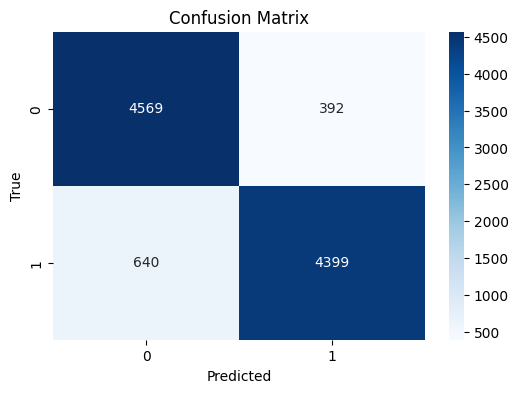


Classification Report:

              precision    recall  f1-score   support

    Negative       0.88      0.92      0.90      4961
    Positive       0.92      0.87      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


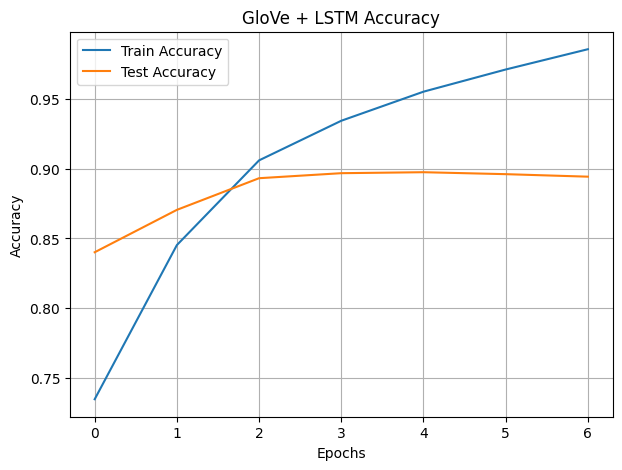

In [ ]:
# Plot accuracy
plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title("GloVe + LSTM Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
